In [29]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
from numpy import zeros_like
from IPython.display import display
def display_matrix(m):
    display(sympy.Matrix(m))
import sympy
import pandas as pd
import scipy.stats as ss

sympy.init_printing()

from Pricer import Pricer
from Processes import Processes
from Processes1 import Processes1
from Processes2 import Processes2

from scipy.stats.qmc import Sobol
from scipy.stats import norm

In [30]:
basis = 'leguerre'

# parameters

mu = 0.06
r = 0.06
T = 1
I = 250
paths = 1000
S0 = 40
S0_list = range(37, 43, 1)
m = 0
K = 40
sigma = 0.04

deg = 3

GBM_sigma = 0.04
GBM_mu = r

LN_lam = 1
LN_sigma = 0.02
LN_mu = r
LN_v = 0.02

JR_lam = 0.01
JR_sigma = 0.03
JR_mu = r + JR_lam

LNparams = (LN_lam, LN_sigma, LN_mu, LN_v, m)
JRparams = (JR_lam, JR_sigma, JR_mu)
GBMparams = (GBM_mu, GBM_sigma)

# instance
processes = Processes(S0, r, T, K, paths, I, LNparams, JRparams, GBMparams)
pricer = Pricer(S0, r, sigma, T, K, paths, I, LNparams, JRparams, GBMparams)
processes1 = Processes1(S0, r, T, K, paths, I, LNparams, JRparams, GBMparams)
processes2 = Processes2(S0, r, T, K, paths, I, LNparams, JRparams, GBMparams)

Processes class created with S0 = 40, paths = 1000, I = 250, T = 1
Processes1 class created with S0 = 40, paths = 1000, I = 250, T = 1
Processes2 class created with S0 = 40, paths = 1000, I = 250, T = 1


# Processes

In [31]:
GBM_paths = processes.gbm_paths_antithetic()
LN_paths = processes.merton_jump_paths_antithetic()
JR_paths = processes.merton_jump_to_ruin_paths_antithetic()

GBM_mean, GBM_std = processes2.gbm_paths_sobol_antithetic_moment_matching_sample()
LN_mean, LN_std, LN_mean_LN, LN_std_LN = processes2.merton_jump_paths_sobol_antithetic_moment_matching_sample()
JR_mean, JR_std= processes2.merton_jump_to_ruin_paths_sobol_antithetic_moment_matching_sample()

gbm_paths_sobol_antithetic_moment_matching = processes2.gbm_paths_sobol_antithetic_moment_matching(GBM_mean, GBM_std)
LN_paths_sobol_antithetic_moment_matching = processes2.merton_jump_paths_sobol_antithetic_moment_matching(LN_mean, LN_std, LN_mean_LN, LN_std_LN)
JR_paths_sobol_antithetic_moment_matching = processes2.merton_jump_to_ruin_paths_sobol_antithetic_moment_matching(JR_mean, JR_std)

# Pricing Functions

In [32]:
def sampling_at_expiry(type, paths, V0_array, V0):
    if type=='GBM':
        paths = paths
        euro_payoff = pricer.closed_formula_GBM(S0, K, T, r, sigma)
        crude_monte_carlo_european = pricer.crude_monte_carlo_european(paths)
        cov = np.cov(crude_monte_carlo_european, V0_array)
        alpha = -cov[0,1]/cov[0,0]
        adjusted_payoff = V0 + alpha * (crude_monte_carlo_european - np.mean(euro_payoff))
        SE = np.std(adjusted_payoff)/np.sqrt(len(paths))
        corr = cov[0, 1] / (np.std(crude_monte_carlo_european) * np.std(V0_array))
        return adjusted_payoff, SE, cov[0,1], corr
    
    elif type=='LN':
        paths = paths
        euro_payoff = pricer.closed_formula_LN(S0, K, T, r, 10000)
        crude_monte_carlo_european = pricer.crude_monte_carlo_european(paths)
        cov = np.cov(crude_monte_carlo_european, V0_array)
        alpha = -cov[0,1]/cov[0,0]
        adjusted_payoff = V0 + alpha * (crude_monte_carlo_european - np.mean(euro_payoff))
        SE = np.std(adjusted_payoff)/np.sqrt(len(paths))
        corr = cov[0, 1] / (np.std(crude_monte_carlo_european) * np.std(V0_array))
        return adjusted_payoff, SE, cov[0,1], corr
    
    else:
        paths = paths
        euro_payoff = pricer.closed_formula_JR(S0, K, T, r, sigma)
        crude_monte_carlo_european = pricer.crude_monte_carlo_european(paths)
        cov = np.cov(crude_monte_carlo_european, V0_array)
        alpha = -cov[0,1]/cov[0,0]
        adjusted_payoff = V0 + alpha * (crude_monte_carlo_european - np.mean(euro_payoff))
        SE = np.std(adjusted_payoff)/np.sqrt(len(paths))
        corr = cov[0, 1] / (np.std(crude_monte_carlo_european) * np.std(V0_array))
        return adjusted_payoff, SE, cov[0,1], corr

In [33]:
def sampling_at_exercise(type, paths, exercise_matrix, V0_array, V0):
    if type == 'GBM':
        european_put_prices = np.zeros_like(exercise_matrix, dtype=float)

        for path in range(exercise_matrix.shape[0]):
            for time in range(exercise_matrix.shape[1]):
                if exercise_matrix[path, time]:
                    S_at_exercise = paths[path, time]
                    t = time * (T / I)  # Current time in years
                    undiscounted_price = pricer.closed_formula_GBM(S_at_exercise, K, T-t, r, sigma)
                    discount_factor = np.exp(-r * t)  # Discount factor back to time 0
                    european_put_prices[path, time] = undiscounted_price * discount_factor

        first_exercise_prices = np.zeros(european_put_prices.shape[0])

        for path in range(european_put_prices.shape[0]):
            # Find the first non-zero price for this path
            first_exercise_price = next((price for price in european_put_prices[path, :] if price > 0), 0)
            first_exercise_prices[path] = first_exercise_price

        crude_monte_carlo_european_GBM = pricer.crude_monte_carlo_european(GBM_paths)

        cov = np.cov(crude_monte_carlo_european_GBM, V0_array)
        corr = cov[0, 1] / (np.std(crude_monte_carlo_european) * np.std(V0_array))

        alpha = -cov[0, 1] / cov[0, 0]

        adjusted_payoff = V0 + alpha * (crude_monte_carlo_european_GBM - np.mean(first_exercise_prices))
        return adjusted_payoff, cov[0,1], corr

    elif type == 'LN':
        european_put_prices = np.zeros_like(exercise_matrix, dtype=float)

        for path in range(exercise_matrix.shape[0]):
            for time in range(exercise_matrix.shape[1]):
                if exercise_matrix[path, time]:
                    S_at_exercise = paths[path, time]
                    t = time * (T / I)
                    undiscounted_price = pricer.closed_formula_LN(S_at_exercise, K, T-t, r, 1000000)
                    discount_factor = np.exp(-r * t)  # Discount factor back to time 0
                    european_put_prices[path, time] = undiscounted_price * discount_factor

        first_exercise_prices = np.zeros(european_put_prices.shape[0])

        for path in range(european_put_prices.shape[0]):
            # Find the first non-zero price for this path
            first_exercise_price = next((price for price in european_put_prices[path, :] if price > 0), 0)
            first_exercise_prices[path] = first_exercise_price

        crude_monte_carlo_european = pricer.crude_monte_carlo_european(LN_paths)

        cov = np.cov(crude_monte_carlo_european, V0_array)

        alpha = -cov[0, 1] / cov[0, 0]
        corr = cov[0, 1] / (np.std(crude_monte_carlo_european) * np.std(V0_array))

        adjusted_payoff = V0 + alpha * (crude_monte_carlo_european - np.mean(first_exercise_prices))
        return adjusted_payoff, cov[0,1], corr

    else:
        european_put_prices = np.zeros_like(exercise_matrix, dtype=float)

        for path in range(exercise_matrix.shape[0]):
            for time in range(exercise_matrix.shape[1]):
                if exercise_matrix[path, time]:
                    S_at_exercise = paths[path, time]
                    t = time * (T / I)  # Current time in years
                    undiscounted_price = pricer.closed_formula_JR(S_at_exercise, K, T-t, r, sigma)
                    discount_factor = np.exp(-r * t)  # Discount factor back to time 0
                    european_put_prices[path, time] = undiscounted_price * discount_factor

        first_exercise_prices = np.zeros(european_put_prices.shape[0])

        for path in range(european_put_prices.shape[0]):
            # Find the first non-zero price for this path
            first_exercise_price = next((price for price in european_put_prices[path, :] if price > 0), 0)
            first_exercise_prices[path] = first_exercise_price

        crude_monte_carlo_european = pricer.crude_monte_carlo_european(JR_paths)

        cov = np.cov(crude_monte_carlo_european, V0_array)

        alpha = -cov[0, 1] / cov[0, 0]
        corr = cov[0, 1] / (np.std(crude_monte_carlo_european) * np.std(V0_array))

        adjusted_payoff = V0 + alpha * (crude_monte_carlo_european - np.mean(first_exercise_prices))
        return adjusted_payoff, cov[0,1], corr

# Pricing

Standard

In [34]:
V0_GBM, V0_array_GBM, SE_GBM, exercise_matrix_GBM, V_GBM = pricer.LSM(GBM_paths, basis, deg)
V0_LN, V0_array_LN, SE_LN, exercise_matrix_LN, V_LN = pricer.LSM(LN_paths, basis, deg)
V0_JR, V0_array_JR, SE_JR, exercise_matrix_JR, V_JR = pricer.LSM(JR_paths, basis, deg)

V0_GBM_VR, V0_array_GBM_VR, SE_GBM_VR, exercise_matrix_GBM_VR, V_GBM_VR = pricer.LSM(gbm_paths_sobol_antithetic_moment_matching, basis, deg)
V0_LN_VR, V0_array_LN_VR, SE_LN_VR, exercise_matrix_LN_VR, V_LN_VR = pricer.LSM(LN_paths_sobol_antithetic_moment_matching, basis, deg)
V0_JR_VR, V0_array_JR_VR, SE_JR_VR, exercise_matrix_JR_VR, V_JR_VR = pricer.LSM(JR_paths_sobol_antithetic_moment_matching, basis, deg)

Expiry

In [35]:
adjusted_payoff_expiry_GBM, SE_expiry_GBM, cov_expiry_GBM, corr_expiry_GBM = sampling_at_expiry('GBM', GBM_paths, V0_array_GBM, V0_GBM)
adjusted_payoff_expiry_LN, SE_expiry_LN, cov_expiry_LN, corr_expiry_LN = sampling_at_expiry('LN', LN_paths, V0_array_LN, V0_LN)
adjusted_payoff_expiry_JR, SE_expiry_JR, cov_expiry_JR, corr_expiry_JR = sampling_at_expiry('JR', JR_paths, V0_array_JR, V0_JR)

adjusted_payoff_expiry_GBM_VR, SE_expiry_GBM_VR, cov_expiry_GBM_VR, corr_expiry_GBM_VR = sampling_at_expiry('GBM', gbm_paths_sobol_antithetic_moment_matching, V0_array_GBM_VR, V0_GBM_VR)
adjusted_payoff_expiry_LN_VR, SE_expiry_LN_VR, cov_expiry_LN_VR, corr_expiry_LN_VR = sampling_at_expiry('LN', LN_paths_sobol_antithetic_moment_matching, V0_array_LN_VR, V0_LN_VR)
adjusted_payoff_expiry_JR_VR, SE_expiry_JR_VR, cov_expiry_JR_VR, corr_expiry_JR_VR = sampling_at_expiry('JR', JR_paths_sobol_antithetic_moment_matching, V0_array_JR_VR, V0_JR_VR)

Exercise

In [36]:
adjusted_payoff_exercise_GBM, cov_exercise_GBM, corr_exercise_GBM = sampling_at_exercise('GBM', GBM_paths, exercise_matrix_GBM, V0_array_GBM, V0_GBM)
adjusted_payoff_exercise_LN, cov_exercise_LN, corr_exercise_LN = sampling_at_exercise('LN', LN_paths, exercise_matrix_LN, V0_array_LN, V0_LN)
adjusted_payoff_exercise_JR, cov_exercise_JR, corr_exercise_JR = sampling_at_exercise('JR', JR_paths, exercise_matrix_JR, V0_array_JR, V0_JR)

adjusted_payoff_exercise_GBM_VR, cov_exercise_GBM_VR, corr_exercise_GBM_VR = sampling_at_exercise('GBM', gbm_paths_sobol_antithetic_moment_matching, exercise_matrix_GBM_VR, V0_array_GBM_VR, V0_GBM_VR)
adjusted_payoff_exercise_LN_VR, cov_exercise_LN_VR, corr_exercise_LN_VR = sampling_at_exercise('LN', LN_paths_sobol_antithetic_moment_matching, exercise_matrix_LN_VR, V0_array_LN_VR, V0_LN_VR)
adjusted_payoff_exercise_JR_VR, cov_exercise_JR_VR, corr_exercise_JR_VR = sampling_at_exercise('JR', JR_paths_sobol_antithetic_moment_matching, exercise_matrix_JR_VR, V0_array_JR_VR, V0_JR_VR)

UnboundLocalError: local variable 'crude_monte_carlo_european' referenced before assignment

SE

In [ ]:
SE_exercise_GBM = np.std(adjusted_payoff_exercise_GBM)/np.sqrt(len(GBM_paths))
SE_exercise_LN = np.std(adjusted_payoff_exercise_LN)/np.sqrt(len(LN_paths))
SE_exercise_JR = np.std(adjusted_payoff_exercise_JR)/np.sqrt(len(JR_paths))

SE_exercise_GBM_VR = np.std(adjusted_payoff_exercise_GBM_VR)/np.sqrt(len(gbm_paths_sobol_antithetic_moment_matching))
SE_exercise_LN_VR = np.std(adjusted_payoff_exercise_LN_VR)/np.sqrt(len(LN_paths_sobol_antithetic_moment_matching))
SE_exercise_JR_VR = np.std(adjusted_payoff_exercise_JR_VR)/np.sqrt(len(JR_paths_sobol_antithetic_moment_matching))

In [ ]:
print('GBM')
print('V0 = {}'.format(V0_GBM))
print('SE = {}'.format(SE_GBM))
print('SE expiry = {}'.format(SE_expiry_GBM))
print('SE exercise = {}'.format(SE_exercise_GBM))
print('cov expiry = {}'.format(cov_expiry_GBM))
print('cov exercise = {}'.format(cov_exercise_GBM))
print('corr expiry = {}'.format(corr_expiry_GBM))
print('corr exercise = {}'.format(corr_exercise_GBM))
print('GBM VR')
print('V0 = {}'.format(V0_GBM_VR))
print('SE = {}'.format(SE_GBM_VR))
print('SE expiry = {}'.format(SE_expiry_GBM_VR))
print('SE exercise = {}'.format(SE_exercise_GBM_VR))
print('cov expiry = {}'.format(cov_expiry_GBM_VR))
print('cov exercise = {}'.format(cov_exercise_GBM_VR))
print('corr expiry = {}'.format(corr_expiry_GBM_VR))
print('corr exercise = {}'.format(corr_exercise_GBM_VR))
print('LN')
print('V0 = {}'.format(V0_LN))
print('SE = {}'.format(SE_LN))
print('SE expiry = {}'.format(SE_expiry_LN))
print('SE exercise = {}'.format(SE_exercise_LN))
print('cov expiry = {}'.format(cov_expiry_LN))
print('cov exercise = {}'.format(cov_exercise_LN))
print('corr expiry = {}'.format(corr_expiry_LN))
print('corr exercise = {}'.format(corr_exercise_LN))
print('LN VR')
print('V0 = {}'.format(V0_LN_VR))
print('SE = {}'.format(SE_LN_VR))
print('SE expiry = {}'.format(SE_expiry_LN_VR))
print('SE exercise = {}'.format(SE_exercise_LN_VR))
print('cov expiry = {}'.format(cov_expiry_LN_VR))
print('cov exercise = {}'.format(cov_exercise_LN_VR))
print('corr expiry = {}'.format(corr_expiry_LN_VR))
print('corr exercise = {}'.format(corr_exercise_LN_VR))
print('JR')
print('V0 = {}'.format(V0_JR))
print('SE = {}'.format(SE_JR))
print('SE expiry = {}'.format(SE_expiry_JR))
print('SE exercise = {}'.format(SE_exercise_JR))
print('cov expiry = {}'.format(cov_expiry_JR))
print('cov exercise = {}'.format(cov_exercise_JR))
print('corr expiry = {}'.format(corr_expiry_JR))
print('corr exercise = {}'.format(corr_exercise_JR))
print('JR VR')
print('V0 = {}'.format(V0_JR_VR))
print('SE = {}'.format(SE_JR_VR))
print('SE expiry = {}'.format(SE_expiry_JR_VR))
print('SE exercise = {}'.format(SE_exercise_JR_VR))
print('cov expiry = {}'.format(cov_expiry_JR_VR))
print('cov exercise = {}'.format(cov_exercise_JR_VR))
print('corr expiry = {}'.format(corr_expiry_JR_VR))
print('corr exercise = {}'.format(corr_exercise_JR_VR))

GBM
V0 = 0.18656908671679154
SE = 0.005438924899753761
SE expiry = 0.0013435348359862357
SE exercise = 0.001343534835986236
cov expiry = 0.012916794738844233
cov exercise = 0.012916794738844233
GBM VR
V0 = 0.3729271080368836
SE = 0.010573229772909847
SE expiry = 0.004143890682367803
SE exercise = 8.846266154466994e-05
cov expiry = 0.09292131461633121
cov exercise = 0.0008504833746164649
LN
V0 = 0.09630011653085044
SE = 0.0049839008481007635
SE expiry = 0.0015578945817453843
SE exercise = 0.0015578945817453843
cov expiry = 0.00811282949662871
cov exercise = 0.00811282949662871
LN VR
V0 = 0.09546134327904983
SE = 0.005444698062932883
SE expiry = 0.0021830328460394456
SE exercise = 8.539411194570108e-05
cov expiry = 0.010434173041976575
cov exercise = -0.0004446949609744033
JR
V0 = 0.5815856342972239
SE = 0.0986939815826203
SE expiry = 0.09861742586935004
SE exercise = 0.09861742586935006
cov expiry = 18.82775554404679
cov exercise = 18.82775554404679
JR VR
V0 = 0.5700754527935902
SE = 0.

Text(0.5, 0, 'Pricing method')

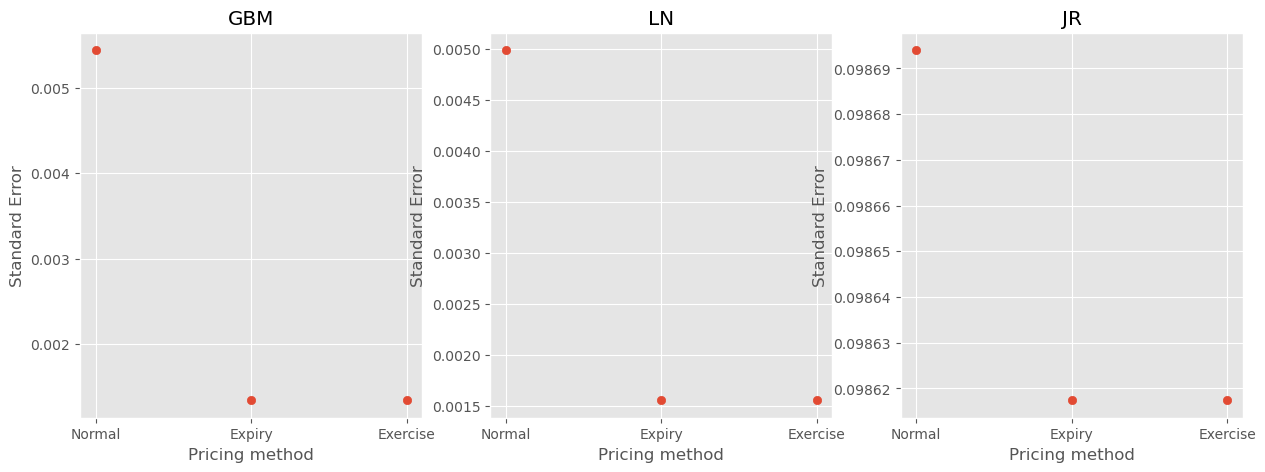

In [ ]:
#create three scatter subplots for each of the different path types and the standard errors for each pricing method. The pricing method on the x axis, i.e. normal, expiry or exercise and the se values on the y axis
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
ax[0,0].scatter(['Normal', 'Expiry', 'Exercise'], [SE_GBM, SE_expiry_GBM, SE_exercise_GBM])
ax[0,0].set_title('GBM')
ax[0,1].scatter(['Normal', 'Expiry', 'Exercise'], [SE_LN, SE_expiry_LN, SE_exercise_LN])
ax[0,1].set_title('LN')
ax[0,2].scatter(['Normal', 'Expiry', 'Exercise'], [SE_JR, SE_expiry_JR, SE_exercise_JR])
ax[0,2].set_title('JR')
ax[1,0].scatter(['Normal', 'Expiry', 'Exercise'], [SE_GBM_VR, SE_expiry_GBM_VR, SE_exercise_GBM_VR])
ax[1,0].set_title('GBM VR')
ax[1,1].scatter(['Normal', 'Expiry', 'Exercise'], [SE_LN_VR, SE_expiry_LN_VR, SE_exercise_LN_VR])
ax[1,1].set_title('LN VR')
ax[1,2].scatter(['Normal', 'Expiry', 'Exercise'], [SE_JR_VR, SE_expiry_JR_VR, SE_exercise_JR_VR])
ax[1,2].set_title('JR VR')
plt.show()

In [ ]:
#create 6 scatter subplots for each of the different path types and the corr values for each pricing method. The pricing method on the x axis, i.e. normal, expiry or exercise and the corr values on the y axis
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0,0].scatter(['Expiry', 'Exercise'], [corr_expiry_GBM, corr_exercise_GBM])
ax[0,0].set_title('GBM')
ax[0,0].set_ylabel('Correlation')
ax[0,0].set_xlabel('Pricing method')
ax[0,1].scatter(['Expiry', 'Exercise'], [corr_expiry_LN, corr_exercise_LN])
ax[0,1].set_title('LN')
ax[0,1].set_ylabel('Correlation')
ax[0,1].set_xlabel('Pricing method')
ax[0,2].scatter(['Expiry', 'Exercise'], [corr_expiry_JR, corr_exercise_JR])
ax[0,2].set_title('JR')
ax[0,2].set_ylabel('Correlation')
ax[0,2].set_xlabel('Pricing method')
ax[1,0].scatter(['Expiry', 'Exercise'], [corr_expiry_GBM_VR, corr_exercise_GBM_VR])
ax[1,0].set_title('GBM VR')
ax[1,0].set_ylabel('Correlation')
ax[1,0].set_xlabel('Pricing method')
ax[1,1].scatter(['Expiry', 'Exercise'], [corr_expiry_LN_VR, corr_exercise_LN_VR])
ax[1,1].set_title('LN VR')
ax[1,1].set_ylabel('Correlation')
ax[1,1].set_xlabel('Pricing method')
ax[1,2].scatter(['Expiry', 'Exercise'], [corr_expiry_JR_VR, corr_exercise_JR_VR])
ax[1,2].set_title('JR VR')
ax[1,2].set_ylabel('Correlation')
ax[1,2].set_xlabel('Pricing method')
plt.show()